# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # either 3 or 6

from data_generators import *
import utils
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.__version__

'1.8.1'

In [1]:
# setup generators / data loaders for training and validation

# we'll make the training data loader in the training loop,
# since we need to update some of the examples used each epoch
train_gen = TrainGenerator("mouse", "CTCF")

source_val_gen = ValGenerator("mouse", "CTCF", batchsize=10000)
# using a batch size of 1 here because the generator returns
# many examples in each batch
source_val_data_loader = DataLoader(source_val_gen, batch_size = 1, shuffle = True)

target_val_gen = ValGenerator("human", "CTCF", batchsize=10000)
target_val_data_loader = DataLoader(target_val_gen, batch_size = 1, shuffle = True)

NameError: name 'TrainGenerator' is not defined

# Model Training And Evaluation

In [6]:
class BasicModel(torch.nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.input_seq_len = 500
        num_conv_filters = 240
        lstm_hidden_units = 32
        fc_layer1_units = 1024
        fc_layer2_units = 512
        
        
        # Defining the layers to go into our model
        # (see the forward function for how they fit together)
        self.conv = torch.nn.Conv1d(4, num_conv_filters, kernel_size=20, padding=0)
        self.relu = torch.nn.ReLU()

        # We'll store performance metrics during training in these lists
        self.train_loss_by_epoch = []
        self.source_val_loss_by_epoch = []
        self.source_val_auprc_by_epoch = []
        self.target_val_loss_by_epoch = []
        self.target_val_auprc_by_epoch = []

        # We'll record the best model we've seen yet each epoch
        self.best_state_so_far = self.state_dict()
        self.best_auprc_so_far = 1

        
        
        ##########
        
        # Defining the layers to go into our model
        # (see the forward function for how they fit together)
        self.conv = torch.nn.Conv1d(4, num_conv_filters, kernel_size=20, padding=0)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(15, stride=15, padding=0)
        self.lstm = torch.nn.LSTM(input_size=num_conv_filters,
                                  hidden_size=lstm_hidden_units,
                                  batch_first=True)
        self.fc1 = torch.nn.Linear(in_features=lstm_hidden_units,
                                   out_features=fc_layer1_units)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(in_features=fc_layer1_units,
                                   out_features=fc_layer2_units)
        self.fc_final = torch.nn.Linear(in_features=fc_layer2_units,
                                        out_features=1)
        self.sigmoid = torch.nn.Sigmoid()

        # The loss function we'll use -- binary cross-entropy
        # (this is the standard loss to use for binary classification)
        self.loss = self.CORAL_loss()

        ##########
        
        
    def forward(self, X):
        return (self.conv(X))
        
    def validation(self, data_loader):
        # only run this within torch.no_grad() context!
        losses = []
        preds = []
        labels = []
        for seqs_onehot_batch, labels_batch in data_loader:
            # push batch through model, get predictions, calculate loss
            preds_batch = self(seqs_onehot_batch.squeeze().cuda())
            labels_batch = labels_batch.squeeze()
            loss_batch = self.loss(preds_batch, labels_batch.cuda())
            losses.append(loss_batch.item())

            # storing labels + preds for auPRC calculation later
            labels.extend(labels_batch.detach().numpy())  
            preds.extend(preds_batch.cpu().detach().numpy())
            
        return np.array(losses), np.array(preds), np.array(labels)

    def convolve(self, data_loader):
        # only run this within torch.no_grad() context!

        # DEBUG
        for seqs_onehot_batch, labels_batch in data_loader:
            print('seqs_onehot_batch:',seqs_onehot_batch.shape)
            print('labels_batch:', labels_batch.shape)
            break
            
        features = []
        for seqs_onehot_batch, labels_batch in data_loader:
            # push batch through model, get predictions, calculate loss
            features_batch = self(seqs_onehot_batch.squeeze().cuda())
            print(features_batch.shape)
            # storing labels + preds for auPRC calculation later
            features.extend(features_batch.cpu().detach().numpy())
#             features.extend(features_batch.cpu().detach().numpy())
        features_all = np.array(features)
        print('features:',features_all.shape)
        return features_all # maybe hold off on converting to numpy to run torch.cov on the gpu?
    
    def loader_to_generator(self, data_loader):
        for batch in data_loader:
            yield batch
    
    def get_cov(self, data_loader, nbatch=100):
        """
        seqs_onehot_batch : (1, batchsize, input_seq_len) [1, 1000, 4, 500]
        convolved_batch : (batchsize, num_conv_filters, input_seq_len - padding) [1000, 240, 481]
        labels_batch : (1, batchsize) [1, 1000]
        cov_batch : ()
        """
        covariances = []
        generator = self.loader_to_generator(data_loader)
        for i in range(nbatch):
            seqs_onehot_batch, labels_batch = next(generator)
            # push batch through model, get predictions, calculate loss
            convolved_batch = self(seqs_onehot_batch.squeeze().cuda())
            cov_batch = np.cov(torch.max(convolved_batch, 2).values.T.cpu().detach().numpy())
            covariances.append(cov_batch)
        print(f'cov of batch {i-nbatch+1} to {i+1}')
        return covariances

In [7]:
model = BasicModel()
model.load_state_dict(torch.load('../models/baseline'))
model.cuda()
print('Getting covariances for source and target...')
src_cov0 = model.get_cov(source_val_data_loader)
src_cov1 = model.get_cov(source_val_data_loader)
tgt_cov0 = model.get_cov(target_val_data_loader)
tgt_cov1 = model.get_cov(target_val_data_loader)
model.cpu()


Getting covariances for source and target...
cov of batch 0 to 100
cov of batch 0 to 100
cov of batch 0 to 100
cov of batch 0 to 100


BasicModel(
  (conv): Conv1d(4, 240, kernel_size=(20,), stride=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=15, stride=15, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(240, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_final): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (loss): BCELoss()
)

In [9]:
norm_diff = lambda A, B: [np.linalg.norm(a - b) for (a,b) in zip(A,B)]

mm = norm_diff(src_cov0, src_cov1)
hm = norm_diff(src_cov0, tgt_cov0)
hh = norm_diff(tgt_cov0, tgt_cov1)
same = norm_diff(tgt_cov0, tgt_cov0)
len(tgt_cov1)

100

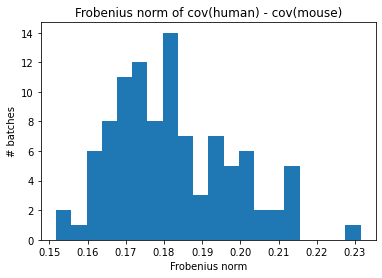

In [10]:
plt.hist(hm, bins=20)
plt.title('Frobenius norm of cov(human) - cov(mouse)')
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')
plt.savefig('cov-hm.jpg')

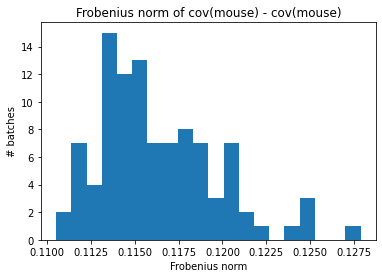

In [11]:
plt.hist(mm, bins=20)
plt.title('Frobenius norm of cov(mouse) - cov(mouse)')
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')
plt.savefig('cov-mm.jpg')

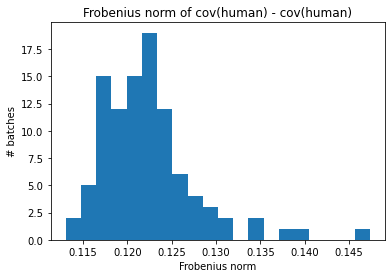

In [12]:
plt.hist(hh, bins=20)
plt.title('Frobenius norm of cov(human) - cov(human)')
plt.xlabel('Frobenius norm')
plt.ylabel('# batches')
plt.savefig('cov-hh.jpg')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

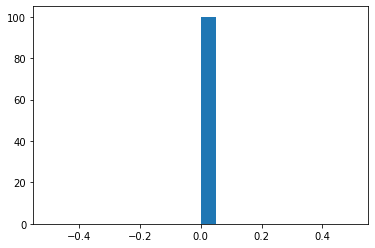

In [13]:
plt.hist(same, bins=20)

In [14]:
print(f'human-human ~ N({round(np.mean(hh),4)}, {round(np.std(hh),4)}^2)')
print(f'human-mouse ~ N({round(np.mean(hm),4)}, {round(np.std(hm),4)}^2)')
print(f'mouse-mouse ~ N({round(np.mean(mm),4)}, {round(np.std(mm),4)}^2)')

human-human ~ N(0.1224, 0.0054^2)
human-mouse ~ N(0.1822, 0.0157^2)
mouse-mouse ~ N(0.1163, 0.0034^2)
